In [1]:
# import all libraries
import pandas as pd
import joblib
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
import matplotlib as plt
from xgboost import plot_importance
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np

In [2]:
# Path settings


path_var = 1 

if (path_var == 1):
    filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
    modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


else:
    filepath = '/home/sharan/Desktop/Option_Pricing/datasets/'
    mdoelpath = '/home/sharan/Desktop/Option_Pricing/pickles/'



nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'
    
bnfty = filepath + 'BANKNIFTY_feature_set_COV_complete.csv'
bnfty_ecdf = filepath + 'BANKNIFTY_feature_set_ECDF_complete.csv'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 1                     #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    n_feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage','strike','spot','opPrice']
    
    b_feats = pd.read_csv(bnfty_ecdf)
    
else:
    n_feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(bnfty)
    
    if (approach == 2):
        dropNames= ['date', 'percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp','avg_atmError']
        
    else:
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        
###################

n_feats = n_feats.drop(dropNames, axis = 1)
b_feats = b_feats.drop(dropNames, axis = 1)

feats = n_feats.append(b_feats, ignore_index=True)

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']    

Approach var set to ECDF


In [4]:

featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)


In [5]:
# # Save the scalar file

joblib.dump(scaler, modelpath + 'SCALER_NF+BNF_Expt' + str(approach) + '.model')
print("Scaler saved to path ::", modelpath + 'SCALER_NF+BNF_Expt' + str(approach) + '.model')

Scaler saved to path :: /home/docboy/Desktop/Option_Pricing/pickles/SCALER_NF+BNF_Expt1.model


In [6]:
# Split the train and test sets without random optimizations


a = len(n_feats)
split_val = round(a*0.8)

# Removing the Random splits

Ntrain = n_feats.iloc[0:split_val, :]
Ntest = n_feats.iloc[split_val:, :]

b = len(b_feats)
split_val = round(b*0.8)

# Removing the Random splits

Btrain = b_feats.iloc[0:split_val, :]
Btest = b_feats.iloc[split_val:, :]


train = Ntrain.append(Btrain, ignore_index=True)

train = train.sample(frac=1).reset_index(drop=True)

test = Ntest.append(Btest, ignore_index=True)

test = test.sample(frac=1).reset_index(drop=True)

X_train=train.iloc[:,:-1]
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = featNames)
Y_train=train.loc[:,'Target']
Y_train = Y_train.values
Y_train = Y_train.reshape(len(Y_train), 1)

X_test=test.iloc[:,:-1]
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = featNames)
Y_test=test.loc[:,'Target']
Y_test = Y_test.values
Y_test = Y_test.reshape(len(Y_test), 1)

print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)

X & Y_Dim of Train is (27147, 22) (27147, 1)
X & Y_Dim of Test is (6786, 22) (6786, 1)


In [7]:
# param = 
model = XGBClassifier(n_estimators = 250, max_depth = 4, learning_rate = 0.25, n_jobs=4)
%time model.fit(X_train, Y_train)
print(model)


/home/docboy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/docboy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 11min 19s, sys: 2.61 s, total: 11min 22s
Wall time: 2min 59s
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=4,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [8]:
k = model.predict(X_test)

In [9]:
# Normalized Error Metric (NEM)

bin_width = 0.1    # Note the uniform binning!!!!!!!!
dist_sum = 0
for i in range(len(k)):
    dist = abs(k[i] - Y_test[i])
    dist_sum = dist_sum + dist
    
print("NEM :: ", (dist_sum*bin_width)/len(Y_test))

NEM ::  [0.18446802]


In [10]:
accuracy_score(Y_test, k)*100
# print(classification_report(Y_test, k))

23.563218390804597

In [11]:
# Saving the model
joblib.dump(model, modelpath + 'NF+BNF_Expt' + str(approach) + '.model')
print("Model saved to path ::", modelpath + 'NF+BNF_Expt_NEW' + str(approach) + '.model' )

Model saved to path :: /home/docboy/Desktop/Option_Pricing/pickles/NF+BNF_Expt_NEW1.model


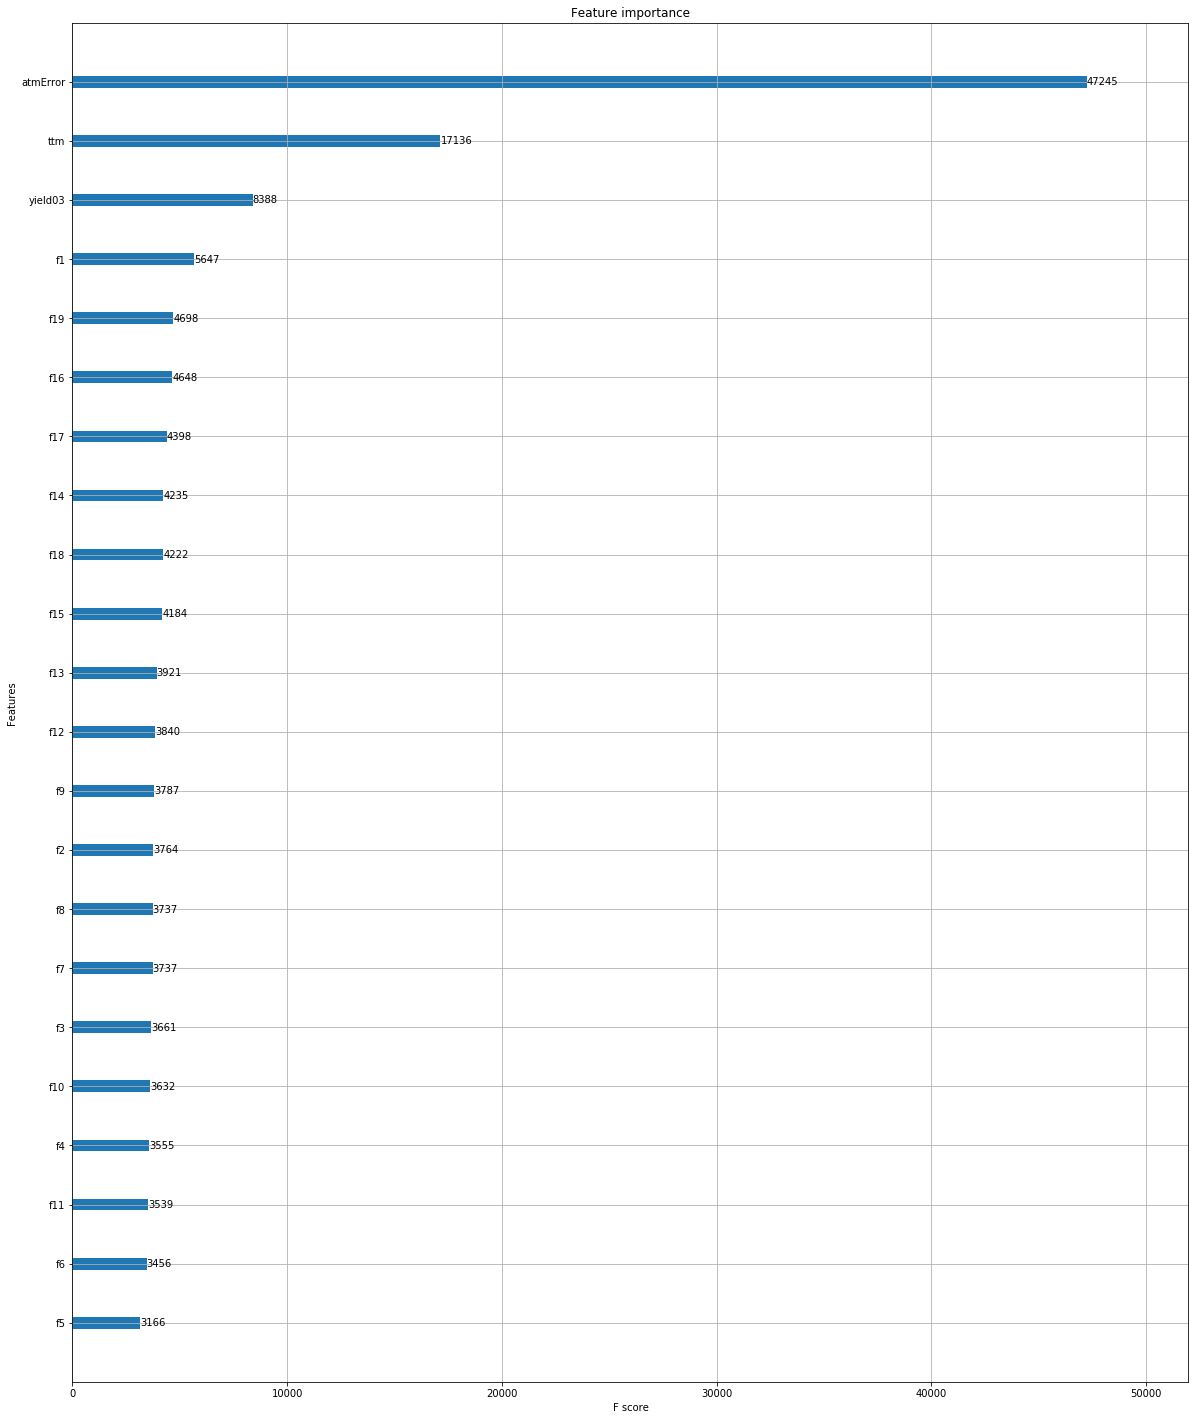

In [12]:
plt.rcParams['figure.figsize'] = [20, 25]
plot_importance(model)
plt.show()

# Testing BNF+NF on NF and BNF separately 

In [13]:
X_test

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f13,f14,f15,f16,f17,f18,f19,ttm,atmError,yield03
0,0.504204,0.181568,0.225148,0.216411,0.117027,0.085132,0.125353,0.297938,0.249093,-0.042563,...,-0.836138,-0.909808,-1.025935,-1.084539,-0.488553,-0.486783,-0.598376,-0.65,0.226363,-0.295918
1,-0.065420,0.531631,0.382839,0.030317,-0.274215,-0.191643,-0.313935,-0.536930,-0.879343,-0.435707,...,-1.353034,-1.457864,-0.512861,-0.614000,-0.646856,-0.388138,-0.517707,-0.65,-0.891025,0.051020
2,0.799484,0.987212,0.957722,0.671640,0.521421,0.398084,0.726414,0.630718,0.912911,0.885533,...,0.341257,0.466133,0.274153,0.155432,-0.072719,-0.389293,-0.512391,0.40,-0.104755,-0.326531
3,-0.000688,-0.392658,-0.231846,-0.142009,0.242522,0.110775,-0.092516,0.282740,0.165649,0.077044,...,-0.132907,0.224220,0.031306,-0.256791,-0.403542,-0.542454,-0.512391,1.10,-0.447186,-0.326531
4,0.552694,0.218974,0.128455,0.103258,1.035992,0.985745,0.825369,0.645497,0.594651,0.304309,...,0.031348,-0.108401,-0.252349,-0.694401,-0.289384,-0.722186,-0.154617,0.20,-0.166693,-0.173469
5,0.552694,0.218974,0.128455,0.103258,1.035992,0.985745,0.825369,0.645497,0.594651,0.304309,...,0.031348,-0.108401,-0.252349,-0.694401,-0.289384,-0.722186,-0.154617,0.20,0.810215,-0.173469
6,0.392106,0.218974,0.128455,0.298503,0.778219,0.826197,0.825369,0.811901,0.597698,0.356173,...,-0.186724,0.136267,0.541028,0.014854,-0.069140,-0.292290,-0.154617,-0.65,0.280970,-0.081633
7,0.717103,0.906894,1.188352,1.048621,1.007676,0.895175,1.006140,0.931224,1.068189,0.884733,...,0.684598,0.333939,0.000000,-0.383109,-0.413679,-0.694638,-0.552195,0.15,-0.869930,-0.010204
8,0.392106,0.218974,0.064798,0.158885,0.027066,0.591559,0.604747,0.677778,0.594651,0.304309,...,-0.484207,0.136267,0.541028,0.014854,-0.069140,-0.292290,-0.154617,-0.55,-0.858276,-0.102041
9,0.504204,0.181568,0.225148,0.216411,0.117027,0.062554,0.352340,0.297938,0.249093,-0.042563,...,-0.842753,-1.398948,-1.032010,-1.399763,-0.959841,-0.929382,-0.651953,0.45,-0.398286,-0.295918


In [16]:
## NF


n_feats = n_feats.sample(frac=1).reset_index(drop=True)

nf_Ytest = n_feats.loc[:, 'Target']
nf_Xtest = n_feats.iloc[:, :-1]

featNames = list(nf_Xtest)

nf_Xtest = scaler.transform(nf_Xtest)
nf_Xtest = pd.DataFrame(nf_Xtest, columns = featNames)


pred = model.predict(nf_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - nf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(nf_Ytest))


NEM :: 0.05269660427609677


In [15]:
## BNF


bnf_Ytest = b_feats.loc[:, 'Target']
bnf_Xtest = b_feats.iloc[:, :-1]

featNames = list(bnf_Xtest)

bnf_Xtest = scaler.transform(bnf_Xtest)
bnf_Xtest = pd.DataFrame(bnf_Xtest, columns = featNames)


pred = model.predict(bnf_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - bnf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(bnf_Ytest))


NEM :: 0.0642682210031348
